### Atlas projection of WT cells
In this script we project each cell onto the WT atlas (after removing the cell from the atlas). We use this projection when we compare the cell type frequency of WT cells with the cell type frequency of projected ex utero cells.

In [1]:
setwd(here::here())

In [2]:
library("metacell")
library("tgstat")
library("Matrix")

In [3]:
scdb_init("scrna_db/")
scfigs_init('figs')

initializing scdb to scrna_db/



In [4]:
mat = scdb_mat("embexe")
mc = scdb_mc("embexe_recolored")

In [5]:
gset = scdb_gset("embexe")
feat_genes = names(gset@gene_set)

In [6]:
# calculating egc per cell
umi_mat = mat@mat[feat_genes,names(mc@mc)]
umi_mat = rbind(umi_mat,colSums(mat@mat[,names(mc@mc)]) - colSums(umi_mat))
rownames(umi_mat)[nrow(umi_mat)] = "other"

egc = t(tgs_matrix_tapply(umi_mat[,names(mc@mc)],mc@mc,sum))
egc = t(t(egc)/colSums(egc))

In [7]:
reg = 1e-5
legc = log2(egc + reg)

In [8]:
umi_sum = t(tgs_matrix_tapply(umi_mat[,names(mc@mc)],mc@mc,sum))
egc_self = umi_sum[,mc@mc] - umi_mat[,names(mc@mc)]

egc_self = t(t(egc_self)/colSums(egc_self))
legc_self = log2(egc_self + reg)
colnames(legc_self) = names(mc@mc)

In [9]:
query_reference_correlation_matrix = tgstat::tgs_cor(as.matrix(log2(mat@mat[feat_genes,names(mc@mc)] + 1)),legc[feat_genes,])

In [10]:
self_covariance = colMeans(log2(umi_mat[feat_genes,names(mc@mc)] + 1) * legc_self[feat_genes,names(mc@mc)]) - colMeans(log2(umi_mat[feat_genes,names(mc@mc)] + 1))*colMeans(legc_self[feat_genes,names(mc@mc)])

In [11]:
umi_mat_variance = apply(log2(umi_mat[feat_genes,names(mc@mc)] + 1),2,var)
legc_self_variance = apply(legc_self[feat_genes,names(mc@mc)],2,var)

In [12]:
self_correlation = self_covariance/sqrt(umi_mat_variance*legc_self_variance)

In [13]:
self_ind = c(1:nrow(query_reference_correlation_matrix)) + nrow(query_reference_correlation_matrix)*(mc@mc - 1)

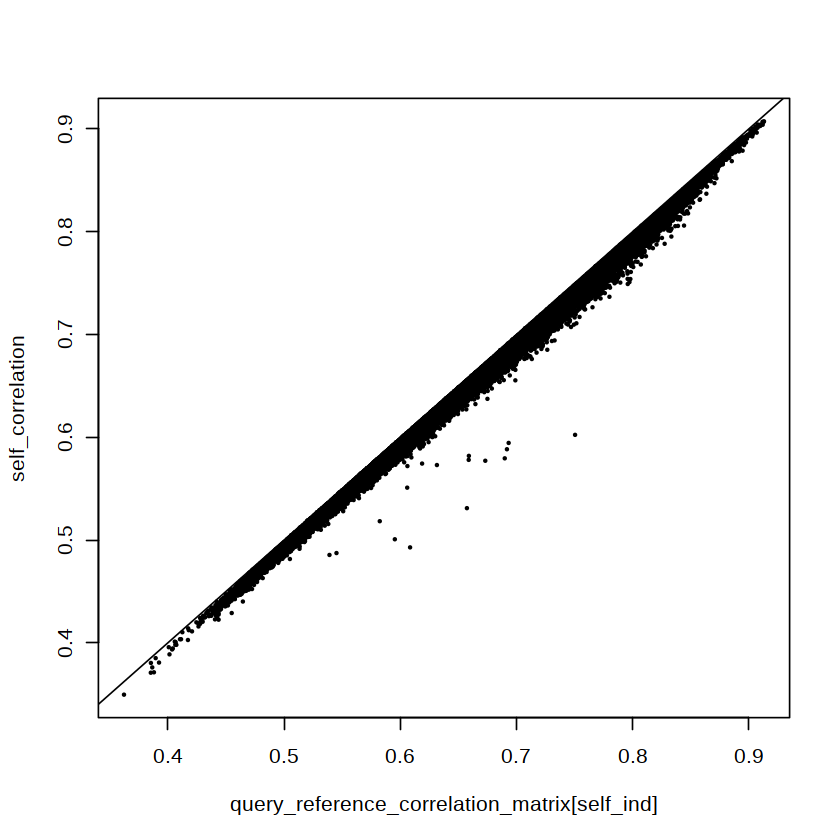

In [14]:
plot(query_reference_correlation_matrix[self_ind],self_correlation,pch = 19, cex = 0.2)
abline(a = 0, b= 1)

In [15]:
old_self_correlation = query_reference_correlation_matrix[self_ind]
query_reference_correlation_matrix[self_ind] = self_correlation

In [16]:
best_reference = apply(query_reference_correlation_matrix,1,which.max)

In [17]:
col_to_ct = mc@color_key$group
names(col_to_ct) = mc@color_key$color

In [18]:
df_annotation = data.frame(cell = names(mc@mc),
                           projected_metacell = best_reference,
                           projected_cell_type = col_to_ct[mc@colors[best_reference]],
                           projected_color = mc@colors[best_reference],
                           original_metacell = mc@mc,
                           original_cell_type = col_to_ct[mc@colors[mc@mc]],
                           original_color = mc@colors[mc@mc])

In [19]:
write.table(x = df_annotation,file = 'data/atlas_self_projection_cell_type.tsv',sep = '\t')